# Data classification using SGDClassifier

In [22]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, f1_score

In [23]:
%run "../../common/matrix.py"
%run "../../common/function_classifier.py"
%run "../../common/Functions.py"
%run "../../common/file_handler.py"
%run "../../common/grid_search_rf.py"
%run "../../common/grid_search_sgd.py"
%run "../../common/plot_functions.py"

In [24]:
PERF_PLOT_XSIZE = 15
PERF_PLOT_YSIZE = 8

In [25]:
SAVE_FIGURE = False

### Import matrix

In [26]:
imported_matrix = open_file_from_fullpath(ask_file_path(), 'r')
matrix_tobe_classified = pd.read_perseus(imported_matrix)

In [27]:
matrix_json = open_file_from_fullpath(ask_file_path(), 'r')

### If matrix has QC, please execute the following cell

In [28]:
matrix_tobe_cl_noqc = slice_submatrix(matrix_tobe_classified,get_value_from_json(matrix_json,'sample_slice'))
dictionary_cl_no_qc, matrix_tobe_cl_noqc = rename_matrixheader_labels(matrix_tobe_cl_noqc, get_value_from_json(matrix_json,'sample_rename'))

#### Labels and features creation

In [29]:
binary_features = create_feature_matrix(matrix_tobe_cl_noqc)
binary_labels = create_labels_binary(matrix_tobe_cl_noqc, 'healthy', 'sick', ['control'], ['local', 'post', 'onset'])
multiclass_features = create_feature_matrix(matrix_tobe_cl_noqc)
multiclass_labels = create_labels(matrix_tobe_cl_noqc)
sick_features = create_feature_matrix(matrix_tobe_cl_noqc, drop='control')
sick_labels = create_labels(matrix_tobe_cl_noqc, drop='control')

In [ ]:
binary_label_1_case = create_labels(matrix_tobe_cl_noqc, drop= ['post', 'local'])
binary_label_2_case = create_labels(matrix_tobe_cl_noqc, drop = ['post', 'onset'])
binary_features_1_case = create_feature_matrix(matrix_tobe_cl_noqc, drop=['post', 'local'])
binary_features_2_case = create_feature_matrix(matrix_tobe_cl_noqc, drop = ['post', 'onset'])

### Global Params for gridsearchCV

In [30]:
params_grid_l2 = {'alpha' : [0.0001, 0.005, 0.01, 0.05, 0.08, 0.1, 0.5, 0.7, 1.5, 1.9], 'penalty': ['l2'], 'loss': ['hinge']}
params_grid_l1 = {'alpha' : [0.0001, 0.005, 0.01, 0.05, 0.08, 0.1, 0.5, 0.7, 1.5, 1.9], 'penalty': ['l1'], 'loss': ['hinge']}
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)

In [31]:
Xbin_train, Xbin_test, ybin_train, ybin_test = train_test_split(binary_features, binary_labels, test_size= 0.20, random_state=0, stratify= binary_labels)
Xmulti_train, Xmulti_test, ymulti_train, ymulti_test = train_test_split(multiclass_features, multiclass_labels, test_size=0.20, random_state=0, stratify= multiclass_labels)
Xsick_train, Xsick_test, ysick_train, ysick_test = train_test_split(sick_features, sick_labels, test_size=0.20, random_state=0, stratify= sick_labels)

In [ ]:
Xbin_OC_train, Xbin_OC_test, ybin_OC_train, ybin_OC_test = train_test_split(binary_features_1_case, binary_label_1_case, test_size= 0.20, random_state=0, stratify= binary_label_1_case)
Xbin_CL_train, Xbin_CL_test, ybin_CL_train, ybin_CL_test = train_test_split(binary_features_2_case, binary_label_2_case, test_size= 0.20, random_state=0, stratify= binary_label_2_case)

### Gridsearch

In [32]:
sgd_grid_l2_binary = grid_search_sgd(features=Xbin_train, labels=ybin_train, parameters=params_grid_l2, cv=skf,  name="", checkpoint_path=None, checkpoint=False)
sgd_grid_l1_binary = grid_search_sgd(features=Xbin_train, labels=ybin_train, parameters=params_grid_l1, cv=skf, name="", checkpoint_path=None, checkpoint=False)

# binary control vs onset
sgd_grid_OC_l2_binary = grid_search_sgd(features=Xbin_OC_train, labels=ybin_OC_train, parameters=params_grid_l2, cv=skf,  name="", checkpoint_path=None, checkpoint=False)
sgd_grid_OC_l1_binary = grid_search_sgd(features=Xbin_OC_train, labels=ybin_OC_train, parameters=params_grid_l1, cv=skf,  name="", checkpoint_path=None, checkpoint=False)

#binary control vs local
sgd_grid_CL_l2_binary = grid_search_sgd(features=Xbin_CL_train, labels=ybin_CL_train, parameters=params_grid_l2, cv=skf,  name="", checkpoint_path=None, checkpoint=False)
sgd_grid_CL_l1_binary = grid_search_sgd(features=Xbin_CL_train, labels=ybin_CL_train, parameters=params_grid_l1, cv=skf,  name="", checkpoint_path=None, checkpoint=False)


sgd_grid_l2_multi = grid_search_sgd(features=Xmulti_train, labels=ymulti_train, parameters=params_grid_l2, cv=skf, name="", checkpoint_path=None, checkpoint=False)
sgd_grid_l1_multi = grid_search_sgd(features=Xmulti_train, labels=ymulti_train, parameters=params_grid_l1, cv=skf, name="", checkpoint_path=None, checkpoint=False)

sgd_grid_l2_sick = grid_search_sgd(features=Xsick_train, labels=ysick_train, parameters=params_grid_l2, cv=skf, name="", checkpoint_path=None, checkpoint=False)
sgd_grid_l1_sick = grid_search_sgd(features=Xsick_train, labels=ysick_train, parameters=params_grid_l1, cv=skf, name="", checkpoint_path=None, checkpoint=False)


Grid search completed!

Grid search completed!

Grid search completed!

Grid search completed!

Grid search completed!

Grid search completed!


### Classifiers

In [33]:
binary_classifier_l2 = SGDClassifier(loss='hinge', penalty='l2', alpha=sgd_grid_l2_binary[0].best_params_['alpha'])
binary_classifier_l2.fit(Xbin_train, ybin_train)
binary_classifier_l1 = SGDClassifier(loss='hinge', penalty='l1', alpha=sgd_grid_l1_binary[0].best_params_['alpha'])
binary_classifier_l1.fit(Xbin_train, ybin_train)

SGDClassifier(penalty='l1')

In [ ]:
binary_OC_classifier_l2 = SGDClassifier(loss='hinge', penalty='l2', alpha=sgd_grid_OC_l2_binary[0].best_params_['alpha'])
binary_OC_classifier_l2.fit(Xbin_OC_train, ybin_OC_train)
binary_OC_classifier_l1 = SGDClassifier(loss='hinge', penalty='l1', alpha=sgd_grid_OC_l1_binary[0].best_params_['alpha'])
binary_OC_classifier_l1.fit(Xbin_OC_train, ybin_OC_train)

In [ ]:
binary_CL_classifier_l2 = SGDClassifier(loss='hinge', penalty='l2', alpha=sgd_grid_CL_l2_binary[0].best_params_['alpha'])
binary_CL_classifier_l2.fit(Xbin_CL_train, ybin_CL_train)
binary_CL_classifier_l1 = SGDClassifier(loss='hinge', penalty='l1', alpha=sgd_grid_CL_l1_binary[0].best_params_['alpha'])
binary_CL_classifier_l1.fit(Xbin_CL_train, ybin_CL_train)

In [34]:
multi_classifier_l2 = SGDClassifier(loss='hinge', penalty='l2', alpha=sgd_grid_l2_multi[0].best_params_['alpha'])
multi_classifier_l2.fit(Xmulti_train, ymulti_train)
multi_classifier_l1 = SGDClassifier(loss='hinge', penalty='l1', alpha=sgd_grid_l1_multi[0].best_params_['alpha'])
multi_classifier_l1.fit(Xmulti_train, ymulti_train)

SGDClassifier(alpha=0.5, penalty='l1')

In [35]:
sick_classifier_l2 = SGDClassifier(loss='hinge', penalty='l2', alpha=sgd_grid_l2_sick[0].best_params_['alpha'])
sick_classifier_l2.fit(Xsick_train, ysick_train)
sick_classifier_l1 = SGDClassifier(loss='hinge', penalty='l1', alpha=sgd_grid_l1_sick[0].best_params_['alpha'])
sick_classifier_l1.fit(Xsick_train, ysick_train)

SGDClassifier(alpha=0.005, penalty='l1')

### Prediction and result printing

In [36]:
ybinary_prediction_l2 = binary_classifier_l2.predict(Xbin_test)
ybinary_prediction_l1 = binary_classifier_l1.predict(Xbin_test)

ybinary_OC_prediction_l2 = binary_OC_classifier_l2.predict(Xbin_OC_test)
ybinary_OC_prediction_l1 = binary_OC_classifier_l1.predict(Xbin_OC_test)

ybinary_CL_prediction_l2 = binary_CL_classifier_l2.predict(Xbin_CL_test)
ybinary_CL_prediction_l1 = binary_CL_classifier_l1.predict(Xbin_CL_test)

ymulti_prediction_l2 = multi_classifier_l2.predict(Xmulti_test)
ymulti_prediction_l1 = multi_classifier_l1.predict(Xmulti_test)

ysick_prediction_l2 = sick_classifier_l2.predict(Xsick_test)
ysick_prediction_l1 = sick_classifier_l1.predict(Xsick_test)

In [37]:
print('All results are :')

print_results(ybin_test, ybinary_prediction_l2)
print('\t')
print_results(ybin_test, ybinary_prediction_l1)
print('binary classification control vs onset')
print_results(ybin_OC_test, ybinary_OC_prediction_l2)
print('\t')
print_results(ybin_OC_test, ybinary_OC_prediction_l1)
print('binary classification control vs local')
print_results(ybin_CL_test, ybinary_CL_prediction_l2)
print('\t')
print_results(ybin_CL_test, ybinary_CL_prediction_l1)
print('multi classification:')
print_results(ymulti_test, ymulti_prediction_l2)
print('\t')
print_results(ymulti_test, ymulti_prediction_l1)
print('multi classification among sick categories:')
print_results(ysick_test, ysick_prediction_l2)
print('\t')
print_results(ysick_test, ysick_prediction_l1)

Accuracy: 1.000
Balanced Accuracy: 1.000
f1 score: 1.000 
	
Accuracy: 1.000
Balanced Accuracy: 1.000
f1 score: 1.000 
	
Accuracy: 0.500
Balanced Accuracy: 0.550
f1 score: 0.392 
	
Accuracy: 0.800
Balanced Accuracy: 0.817
f1 score: 0.804 
	
Accuracy: 0.688
Balanced Accuracy: 0.678
f1 score: 0.675 
	
Accuracy: 0.688
Balanced Accuracy: 0.689
f1 score: 0.696 


### Creation of the dataframe that contains the accuracy score for each classifier

In [38]:
binary_df = create_dataframe(['X', 'Y'], [[binary_classifier_l2.penalty, binary_classifier_l1.penalty], 
[balanced_accuracy_score(ybin_test, ybinary_prediction_l2), balanced_accuracy_score(ybin_test, ybinary_prediction_l1)]])


binary_df_OC = create_dataframe(['X', 'Y'], [[binary_OC_classifier_l2.penalty, binary_OC_classifier_l1.penalty], 
[balanced_accuracy_score(ybin_OC_test, ybinary_OC_prediction_l2), balanced_accuracy_score(ybin_OC_test, ybinary_OC_prediction_l1)]])

binary_df_CL = create_dataframe(['X', 'Y'], [[binary_CL_classifier_l2.penalty, binary_CL_classifier_l1.penalty], 
[balanced_accuracy_score(ybin_CL_test, ybinary_CL_prediction_l2), balanced_accuracy_score(ybin_CL_test, ybinary_CL_prediction_l1)]])

multi_df = create_dataframe(['X', 'Y'], [[multi_classifier_l2.penalty, multi_classifier_l1.penalty],
[balanced_accuracy_score(ymulti_test, ymulti_prediction_l2), balanced_accuracy_score(ymulti_test, ymulti_prediction_l1)]])

sick_df = create_dataframe(['X', 'Y'], [[sick_classifier_l2.penalty, sick_classifier_l1.penalty],
[balanced_accuracy_score(ysick_test, ysick_prediction_l2), balanced_accuracy_score(ysick_test, ysick_prediction_l1)]])

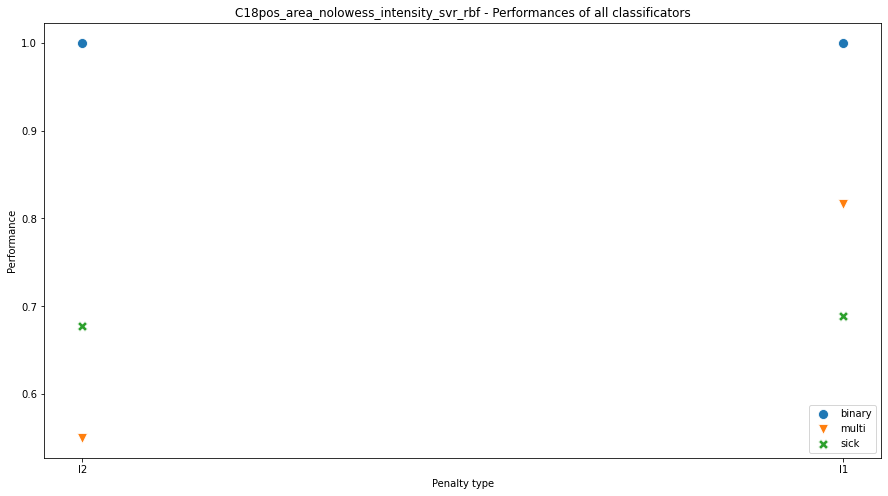

In [39]:
performances = display_performances_wl([binary_df, multi_df, sick_df], get_file_name(imported_matrix) + ' - Performances of all classificators', 'Penalty type', 'Performance', PERF_PLOT_XSIZE, PERF_PLOT_YSIZE, ['o', 'v', 'X'], 100, ['binary', 'multi', 'sick'], fig_save=True, fig_path=merge_path_filename(get_file_path(imported_matrix), get_file_name(imported_matrix), '_SGD_performances_all_classificators', '.svg'))

In [ ]:
performances = display_performances_wl([binary_df_OC, binary_df_CL], get_file_name(imported_matrix) + ' - Performances of all binary classificators ', 'Penalty type', 'Performance', PERF_PLOT_XSIZE, PERF_PLOT_YSIZE, ['o', 'v'], 100, ['binary_OC', 'binary_CL'] , fig_save=True, fig_path=merge_path_filename(get_file_path(imported_matrix), get_file_name(imported_matrix), '_SGD_performances_all_binary_classificators_caseOC_CL', '.svg'))

### Confusion matrices

In [40]:
cm_binary_l2 = confusion_matrix(ybin_test, ybinary_prediction_l2,normalize='pred')
cm_binary_l1 = confusion_matrix(ybin_test, ybinary_prediction_l1,normalize='pred')

# control vs onset
cm_binary_OC_l2 = confusion_matrix(ybin_OC_test, ybinary_OC_prediction_l2,normalize='pred')
cm_binary_OC_l1 = confusion_matrix(ybin_OC_test, ybinary_OC_prediction_l1,normalize='pred')

# control vs local
cm_binary_CL_l2 = confusion_matrix(ybin_CL_test, ybinary_CL_prediction_l2,normalize='pred')
cm_binary_CL_l1 = confusion_matrix(ybin_CL_test, ybinary_CL_prediction_l1,normalize='pred')

cm_multi_l2= confusion_matrix(ymulti_test, ymulti_prediction_l2,normalize='pred')
cm_multi_l1 = confusion_matrix(ymulti_test, ymulti_prediction_l1,normalize='pred')

cm_sick_l2 = confusion_matrix(ysick_test, ysick_prediction_l2,normalize='pred')
cm_sick_l1 = confusion_matrix(ysick_test, ysick_prediction_l1,normalize='pred')

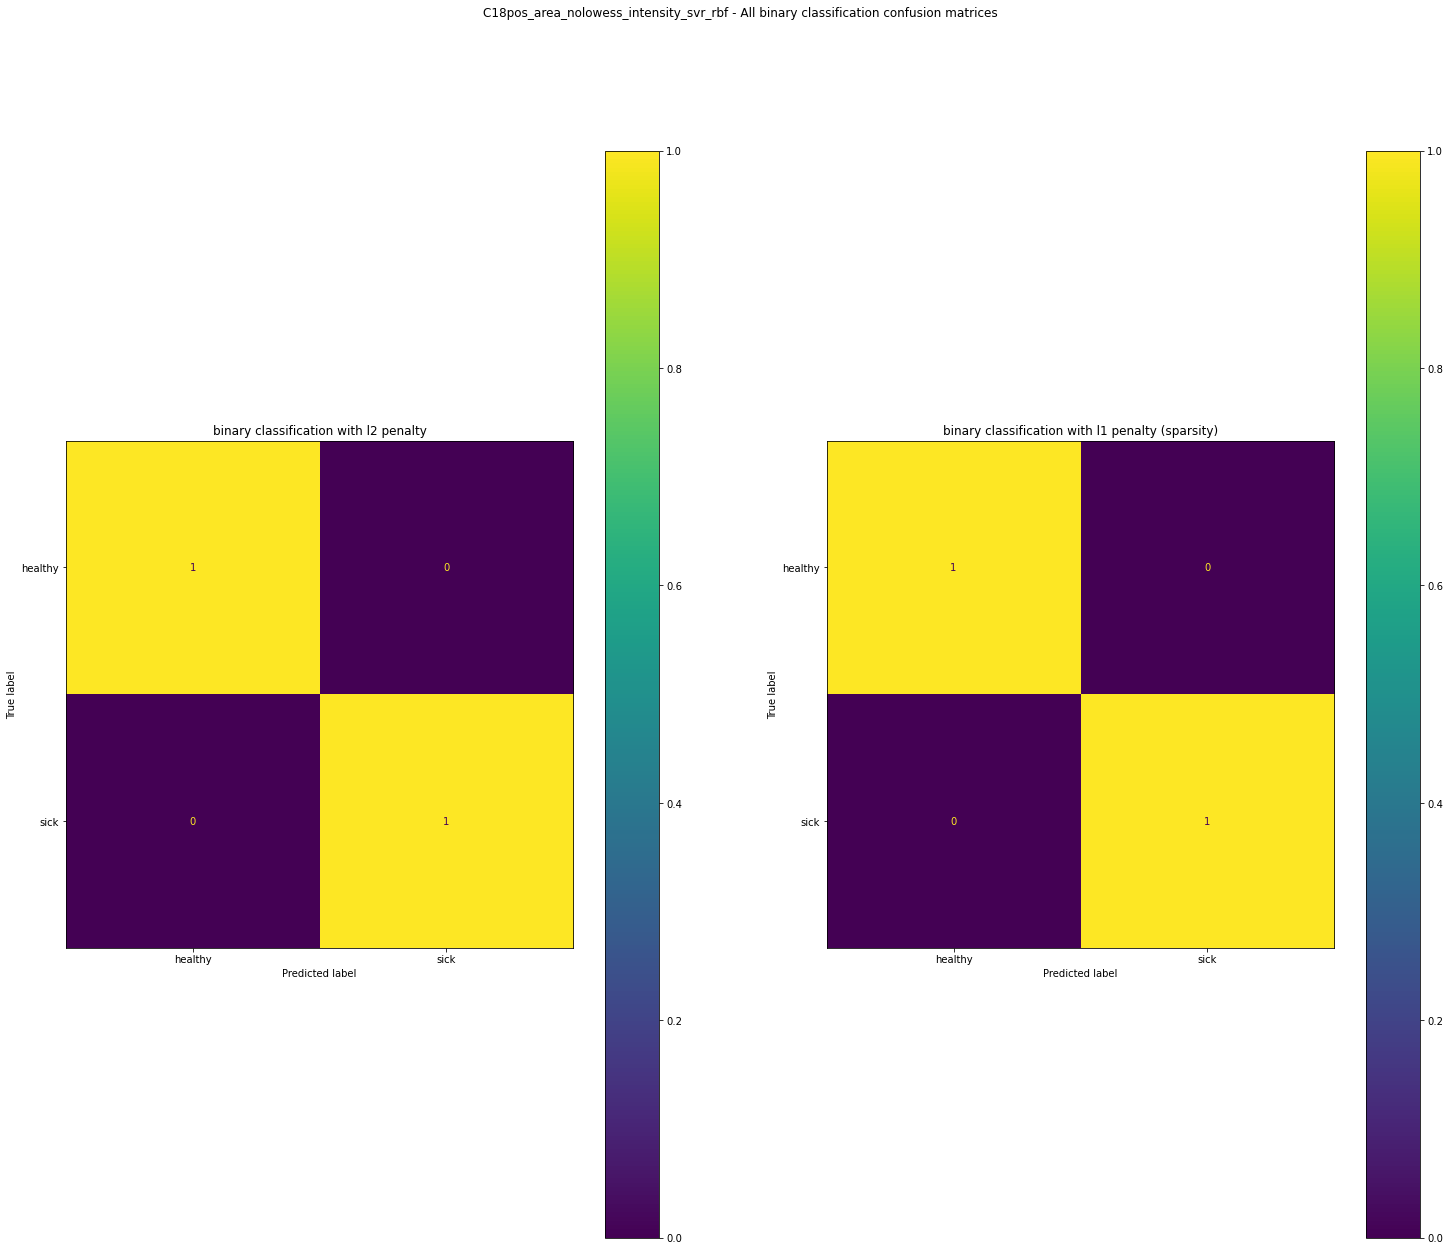

In [42]:
display_confusion_matrices = function_subplots_confusionmatrix([cm_binary_l2, cm_binary_l1], 1, 2, ['binary classification with l2 penalty', 'binary classification with l1 penalty (sparsity)'], get_file_name(imported_matrix) + ' - All binary classification confusion matrices', 25 , 20, labels = [binary_classifier_l1.classes_, binary_classifier_l2.classes_], fig_save= SAVE_FIGURE, fig_path=merge_path_filename(get_file_path(imported_matrix), get_file_name(imported_matrix), '_SGD_confusion_matrix_binary', '.svg'))

In [ ]:
display_confusion_matrices = function_subplots_confusionmatrix([cm_binary_CL_l2, cm_binary_CL_l1], 1, 2, ['binary classification control vs local with l2 penalty', 'binary classification control vs local  with l1 penalty (sparsity)'], get_file_name(imported_matrix) + ' - All binary classification confusion matrices control vs local', 25 , 20, labels = [binary_CL_classifier_l1.classes_, binary_CL_classifier_l2.classes_], fig_save=SAVE_FIGURE, fig_path=merge_path_filename(get_file_path(imported_matrix), get_file_name(imported_matrix), '_SGD_confusion_matrix_binary_CL', '.svg'))

In [ ]:
display_confusion_matrices = function_subplots_confusionmatrix([cm_binary_OC_l2, cm_binary_OC_l1], 1, 2, ['binary classification control vs onset with l2 penalty', 'binary classification with control vs onset l1 penalty (sparsity)'], get_file_name(imported_matrix) + ' - All binary classification confusion matrices control vs onset', 25 , 20, labels = [binary_OC_classifier_l1.classes_, binary_OC_classifier_l2.classes_], fig_save= SAVE_FIGURE, fig_path=merge_path_filename(get_file_path(imported_matrix), get_file_name(imported_matrix), '_SGD_confusion_matrix_binary_OC', '.svg'))

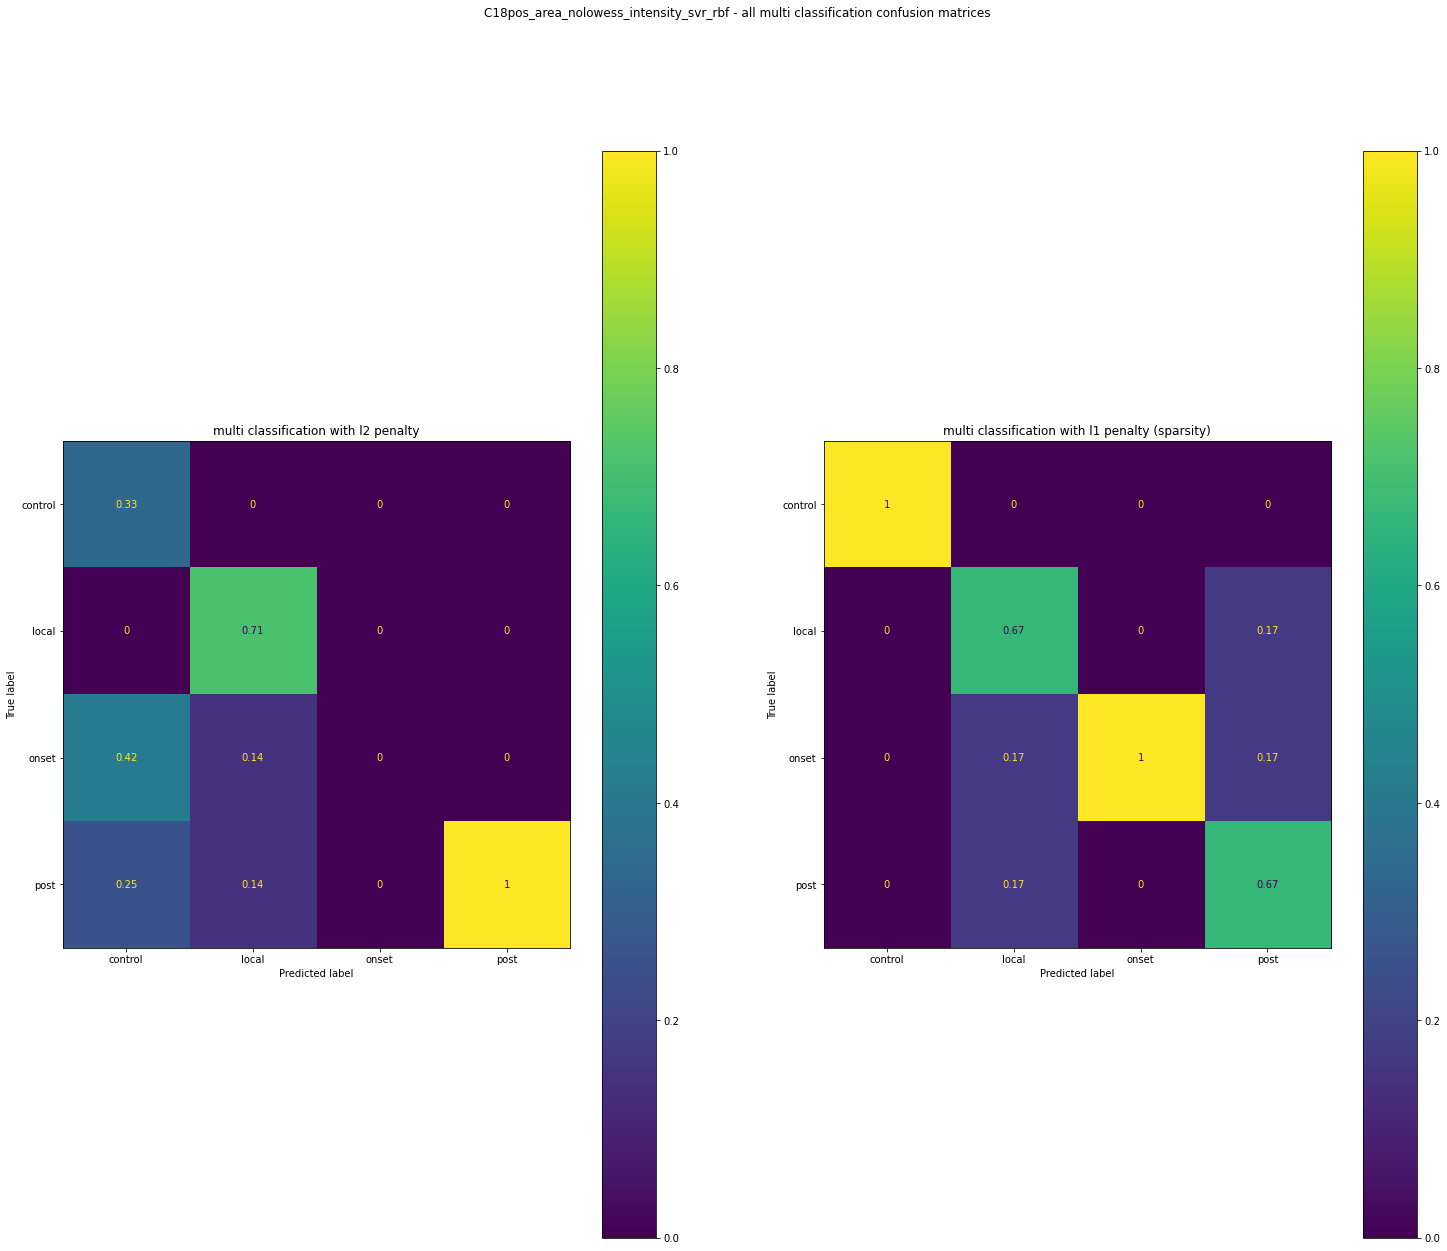

In [43]:
display_confusion_matrices = function_subplots_confusionmatrix([ cm_multi_l2, cm_multi_l1], 1, 2, ['multi classification with l2 penalty', 'multi classification with l1 penalty (sparsity)'], get_file_name(imported_matrix) + ' - all multi classification confusion matrices', 25 , 20, labels = [ multi_classifier_l1.classes_, multi_classifier_l2.classes_], fig_save= SAVE_FIGURE, fig_path=merge_path_filename(get_file_path(imported_matrix), get_file_name(imported_matrix), '_SGD_confusion_matrix_multi', '.svg'))

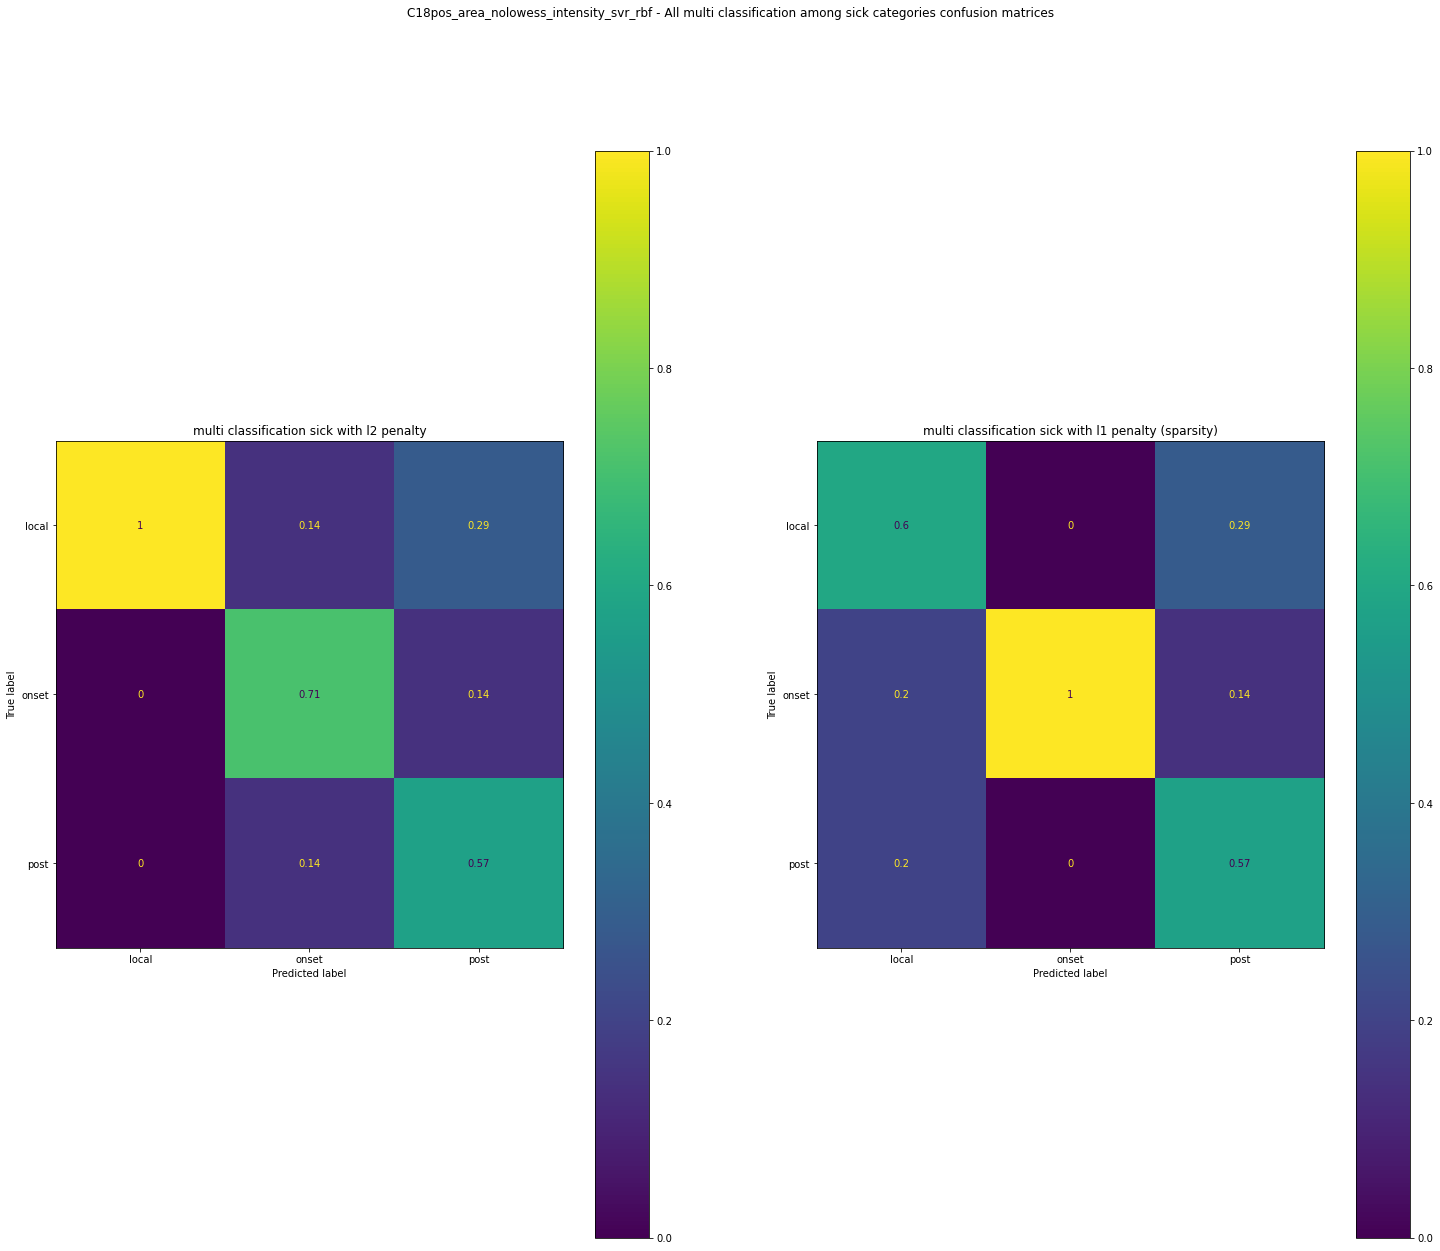

In [44]:
display_confusion_matrices = function_subplots_confusionmatrix([ cm_sick_l2, cm_sick_l1], 1, 2, ['multi classification sick with l2 penalty', 'multi classification sick with l1 penalty (sparsity)'], get_file_name(imported_matrix) + ' - All multi classification among sick categories confusion matrices', 25 , 20, labels = [ sick_classifier_l1.classes_, sick_classifier_l2.classes_], fig_save= SAVE_FIGURE, fig_path=merge_path_filename(get_file_path(imported_matrix), get_file_name(imported_matrix), '_SGD_confusion_matrix_multisick', '.svg'))

In [74]:
imported_matrix.close()
matrix_json.close()